<a href="https://colab.research.google.com/github/desabuh/IncomeClassification/blob/master/IncomeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,entropy
%matplotlib inline

Il dataset in questione è stato estratto da Ron Kohavi nel 1996 dall'ufficio di censimento degli stati uniti d'america (in particolare a partire da una rilevazione del 1994).
Contiene circa 30.000 record rappresentanti determinate unità di individui, ognuna di esse è etichettata con un valore di income binario (<=50K o >50K).
L'obbiettivo di questa analisi è estrarre informazioni statistiche interessanti tramite una prima fase di EDA ed addestrare un modello di classificazione binaria per estrarne caratteristiche utili.

FONTI E RICONOSCIMENTI

1.   http://robotics.stanford.edu/~ronnyk/nbtree.pdf
2.   https://www.census.gov/en.html
3.   https://arxiv.org/pdf/1106.1813.pdf
4.   https://seaborn.pydata.org/
5.   https://www.researchgate.net/publication/328315720_Cross-Validation_for_Imbalanced_Datasets_Avoiding_Overoptimistic_and_Overfitting_Approaches
6. https://xgboost.readthedocs.io/en/latest/
7. https://github.com/slundberg/shap




#Caricamento del dataset e pre-analisi

Il dataset è disponibile su https://www.kaggle.com/uciml/adult-census-income

In [48]:
path = "/adult_income/adult.csv"
data = pd.read_csv(path, nrows=10);

Prima di caricare l'intero dataframe risulta utile caricare solo un numero limitato di record per contrallare i dati

In [49]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Le feature attuali sono:


*   age -> 17-90 ages range of values
*   **workclass ->** categories of workers(government, self-employed...)
*   **fnlwgt ->** final weight, it rappresent the number of people unit for a single row
*   **education ->** level of education achieved for the unit(it will be used only as a dictionary for **education.num**)
*   **education.num ->** Label encoded education (the various type of education can be treated like ordinal values). It will be used instead of **education** 
*   **marital.status ->** marital status for each unit of people
*   **occupation ->** specific working role
*   **relationship ->** relation status
*   **ethnicity(race) ->** ethnicity of the individuals
*   **sex ->** sex of the individual
*   **capital gain/loss ->** only applied on financial instrument buyers, it's a small percentage of people out of the total.
*   **hours.per.week ->** number of hours of work per week
*   **native.country ->** contry of origin
*   **income ->** target variable, high (>50K) or low (<=50K) income for unit



In [50]:
data.shape

(10, 15)

In [51]:
data.drop(columns = "income", inplace=True)

qualitative = [cl for cl in data.columns if data[cl].dtype == "object" or data[cl].dtype.name == "category"]
quantitative = [cl for cl in data.columns if data[cl].dtype != "object" and data[cl].dtype.name != "category"]

In [52]:
qualitative

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

In [53]:
quantitative

['age',
 'fnlwgt',
 'education.num',
 'capital.gain',
 'capital.loss',
 'hours.per.week']

Si ricarica il dataset per risparmiare memoria nel memorizzare le variabili categoriche come category invece che object

In [54]:
data = pd.read_csv(path, dtype={c: "category" for c in qualitative})

In questo caso sostituire le variabili object ha portato ad una dimensione
risultante del dataframe di 3.7Mb (contro 20Mb di occupazione)

In [55]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       32561 non-null  category
 2   fnlwgt          32561 non-null  int64   
 3   education       32561 non-null  category
 4   education.num   32561 non-null  int64   
 5   marital.status  32561 non-null  category
 6   occupation      32561 non-null  category
 7   relationship    32561 non-null  category
 8   race            32561 non-null  category
 9   sex             32561 non-null  category
 10  capital.gain    32561 non-null  int64   
 11  capital.loss    32561 non-null  int64   
 12  hours.per.week  32561 non-null  int64   
 13  native.country  32561 non-null  category
 14  income          32561 non-null  object  
dtypes: category(8), int64(6), object(1)
memory usage: 3.7 MB


#EDA

In [56]:
data.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Nel dataset i valori nulli sono marcati con `?` pertanto prima di valutarli conviene trasformarli in `np.NaN`.





In [57]:
data = data.replace("?", np.NaN)

Il numero di valori mancanti risulta abbastanza trascurabile (una media di 1300 row su 32561 e per sole 3 feature su 14)

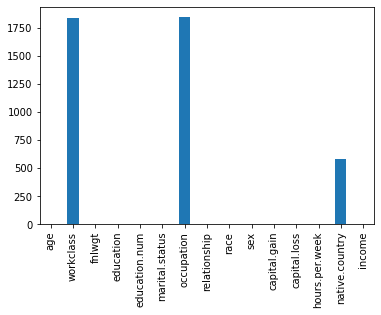

In [58]:
data.isnull().sum().plot.bar();

Si può notare invece uno sbilanciamento significativo relativo alla cardinalità delle 2 fasce di guadagno (tendenzialmente gli alti redditi sono meno frequenti)

In [59]:
data["income"].replace({"<=50K": "Low_income", ">50K": "High_income"}, inplace=True)

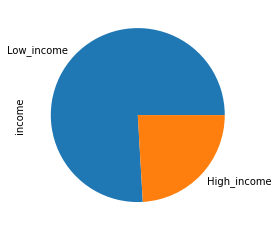

In [60]:
data["income"].value_counts().plot.pie();

In [61]:
data["income"].value_counts()

Low_income     24720
High_income     7841
Name: income, dtype: int64

E' necessario contestualizzare la rilevazione considerando il rateo di dati per ogni paese

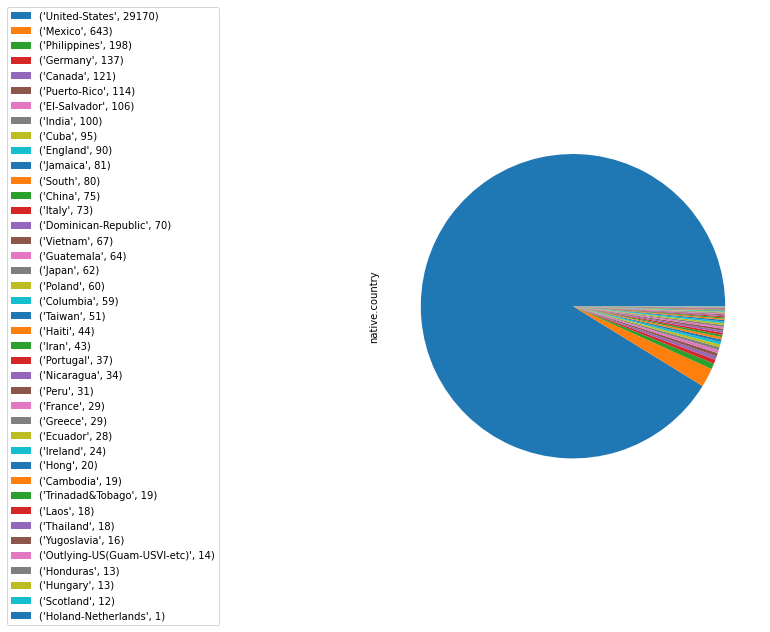

In [62]:
data["native.country"].value_counts().plot(kind = "pie", labels = [''] * data["native.country"].value_counts().size, figsize = (12,7));
plt.legend(labels = list(zip(data["native.country"].value_counts().index, data["native.country"].value_counts())), loc = "upper left", bbox_to_anchor = (-1, 1.3));

Nonostante sia difficile interpretare direttamente il rateo di origini nazionali minori con un plot chart, si può individuare chiaramente come il numero di rilevazioni su unità degli USA sia estremamente preponderante (corrispondente solo essa ad oltre il 90% dei sample a disposizione). Questo è prevedibile in quanto la rilevazione è stata intrapesa dall'ufficio di censimento degli USA.
Le altre 2 fasce maggiori per frequenza sono le nazionalità Messicane e Filippine. 

------------------------------------------------------

Si può notare dalla distribuzione delle feature quantitative diverse caratteristiche:


*   i valori di capital gain/loss sono attivi solo per una piccolissima porzione di unità
*   i dati si riferiscono perlopiù ad individui con circa 40 ore settimali( quindi ci si riferisce principalmente a lavoratori a tempo pieno).
*   le età dei campioni sembrano distribuite in maniera perlopiù omogenea, prediligendo valori di età fra 35-45 anni







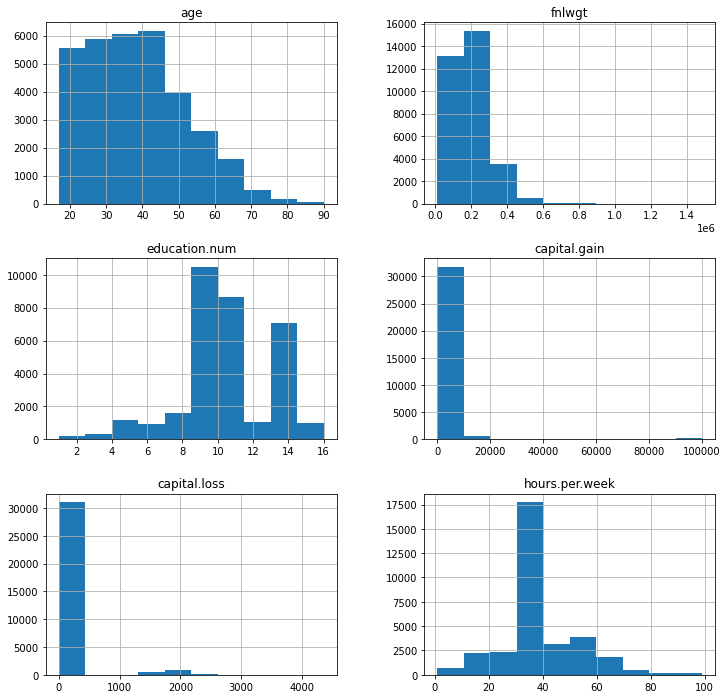

In [63]:
data[quantitative].hist(figsize = (12,12));

Nel caso delle variabili categoriche può essere utile individuare il numero di valori assunti da ognuna per semplificare la fase successiva di encoding

Per scegliere il miglior encoding risulta utile individuare il numero di valori per colonna

In [64]:
cat_var_sizes = data[qualitative].apply(lambda x: x.cat.categories.size)

workclass          8
education         16
marital.status     7
occupation        14
relationship       6
race               5
sex                2
native.country    41
dtype: int64


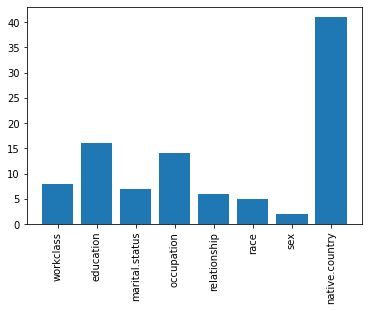

In [65]:
plt.bar(data[qualitative].columns, cat_var_sizes.values)
plt.xticks(rotation=90);
print(cat_var_sizes)

In questo caso l'idea è quella di utilizzare il target encoding per le variabili ad alta cardinalità(native.country) in quanto è un encoding che rende meglio con grandi quantità di valori associati; per i rimanenti invece si può utilizzare il one-hot encoding. In questo caso l'unica eccezione è education, la quale, essendo l'unica variabile categorica ordinale può essere trattata con label encoding(si utilizza la colonna già esistente education.num)

In [66]:
education_dict = dict(zip(data["education.num"], data["education"]))
qualitative.remove("education")
data.drop(columns="education", inplace=True)

In [67]:
high_card_cat = data[qualitative].loc[:,(cat_var_sizes > 20)].columns
low_card_cat = data[qualitative].loc[:,(cat_var_sizes <= 20)].columns

In [68]:
data["native.country"] = data["native.country"].map(
  data[["native.country","income"]].replace({"Low_income": 0, "High_income": 1}).groupby("native.country")["income"].mean()
)

A questo punto può risultare utile individuare il grado di correlazione lineare tra feature numeriche


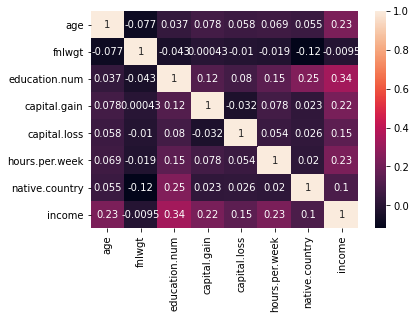

In [69]:
data.replace({"High_income" : 1, "Low_income" : 0}, inplace=True)
sns.heatmap(data.corr(), annot = True);

Fortunatamente non ci sono relazioni di codipendenza elevate tra le feature.
Si può notare inoltre che la feature fnlwgt risulta essere estremamente poco correlata con il valore di income. Una possibile motivazione potrebbe essere che, essendo questa un semplice indicatore del numero di individui per unità(row) tende a risultare un metadato trascurabile nella predizione finale.

Una feature con un certo grado di correlazione, è il livello di educazione(in questo caso nonostante i livelli di istruzione non rappresentino una feature continua, si è scelto di rappresentarla ugualmente con un secondo grafico a distribuzione, per individuare meglio la variazione progressiva dell'income al variare del grado di istruzione, utilizzando anche una kde per aumentare la comprensibilità)

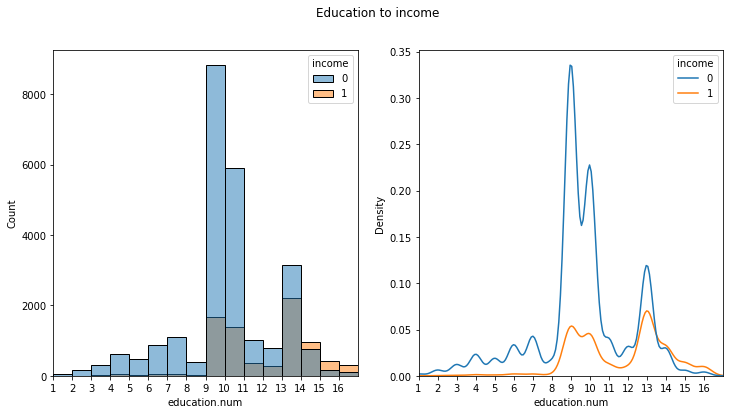

In [70]:
fig, axes = plt.subplots(1, 2, figsize = (12,6))

fig.suptitle("Education to income")

axes[1].set(xlim = (1,17))
axes[0].set(xlim = (1,17))

axes[0].set_xticks(np.arange(1,17))
axes[1].set_xticks(np.arange(1,17))


sns.histplot(x = "education.num", hue = "income", data = data, ax = axes[0], bins = 16, binrange=(1,17))

#o alternativamente
#data.pivot(columns = "income")["education.num"].plot.hist(bins=16, stacked=True, ax = axes[0]);

sns.kdeplot(x = "education.num", hue = "income", data = data, ax = axes[1])

plt.show()

In [71]:
print([education_dict[x] for x in range(14,17)])
print([education_dict[x] for x in range(1,9)])

['Masters', 'Prof-school', 'Doctorate']
['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th']


Si può notare come i bassi redditi abbiano una certa relazione con il grado di istruzione, in particolare:


*   Per livelli di istruzione sotto la scuola superiore (< 12th grade) il numero di alti redditi è estremamente basso 
*   Per livelli di istruzione sopra quello universitario (master, doctorate...) risultano invece molto più diffusi



Si osserva di seguito eventuali relazioni importanti tra la classe lavorativa dell'individuo e il numero di ore settimanali

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


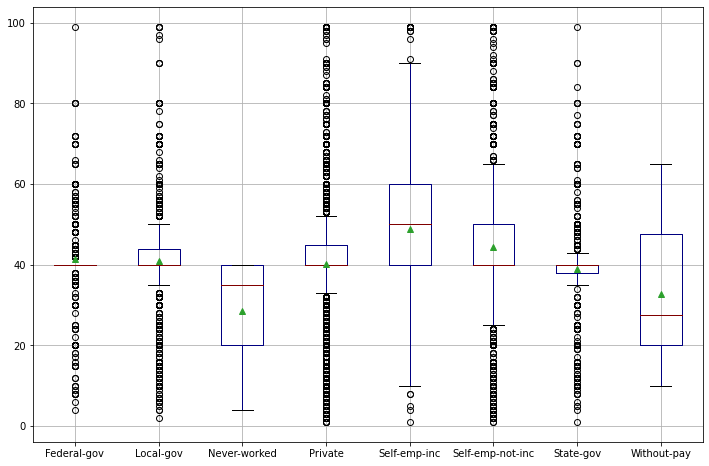

In [72]:
data.pivot(columns = "workclass")["hours.per.week"].iloc[:,1:].plot(kind = "box", showmeans = True, figsize = (12,8), grid =True, colormap = "jet");

Si possono notare nuovamente diverse caratteristiche:


*   I lavoratori autonomi lavorano tendenzialmente più ore per settimana
*   Le cariche governative(federale, locale, statale) ragionevolmente hanno la minore varianza dei dati per le ore di lavoro, concentrate quasi tutte intorno alle 40 ore.
*   Le cariche che non richiedono pagamento (probabilmente tirocini, apprendistati) ha tendenzialmente un numero di ore lavorative in genere sotto le 40 ore, anche se vi sono molti dati anche per quantità di lavoro superiori alle 40 ore. 



#Categorical encoding

In [73]:
X = data.drop(columns = "income")
Y = data["income"]

X.bfill(inplace=True)

In [74]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

one_hot_encoder = OneHotEncoder(sparse=False)
std_scaler = StandardScaler()

In questo caso si standardizzano le feature numeriche e quelle categoriche già trasformate con target encoding, il resto si trasforma con one-hot encoding

In [75]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ("num_and_categorical_high", std_scaler , quantitative + high_card_cat.tolist()),
    ( "categorical_low", one_hot_encoder , low_card_cat )
])


In [76]:
X = preprocessor.fit_transform(X)

In [77]:
preprocessor.named_transformers_["categorical_low"].get_feature_names(low_card_cat)

array(['workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay',
       'marital.status_Divorced', 'marital.status_Married-AF-spouse',
       'marital.status_Married-civ-spouse',
       'marital.status_Married-spouse-absent',
       'marital.status_Never-married', 'marital.status_Separated',
       'marital.status_Widowed', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'relationship_Husband',
       'relationship_Not-in-family', 'r

In [78]:
full_columns_name = quantitative + high_card_cat.tolist() +  preprocessor.named_transformers_["categorical_low"].get_feature_names(low_card_cat).tolist()

#Preparazione per la modellazione

In [79]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [80]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(5, shuffle=True, random_state=10)

In [81]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report

def rand_search_cv(X_t, Y_t, X_v, Y_v, pipeline, grid, n_r_params,scoring, n_jobs = 1, refit = "f1_score"):
  gs = RandomizedSearchCV(pipeline, grid, n_iter = n_r_params, cv=kf, scoring = scoring, refit = refit, n_jobs=n_jobs)
  gs.fit(X_t, Y_t)
  
  y_pred = gs.predict(X_v)

  print(f"Best params : {gs.best_params_}")
  print(f"Best training score : {gs.best_score_}")

  print("\n TRAINING TIME \n")
  print(pd.DataFrame({k:v for k,v in gs.cv_results_.items() if k.endswith("time")}).mean())

  print("\n VALIDATION SET RESULTS\n")
  print(classification_report(Y_v, y_pred))



  return gs

In [82]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

def display_f1_score_tradeoff(estimator):
  hyp_scores = cross_val_predict(estimator, X, Y, cv = kf, method = "decision_function")
  precisions, recalls, thresholds = precision_recall_curve(Y, hyp_scores)

  plt.plot(thresholds, precisions[:-1], label = "precision")
  plt.plot(thresholds, recalls[:-1], label = "recall")
  plt.plot(thresholds, (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1]), label = "f1", c = "red")
  plt.legend()
  plt.yticks(np.arange(0,1,0.1))
  plt.show()

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 42)

# Analisi iniziale con Logistic regression / SMOTE / undersampling e prime considerazioni sui risultati

Prima di eseguire il tuning degli iperparametri risulta utile valutare le performance medie di un modello standard

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lg1 = LogisticRegression(solver="saga", random_state=42)

lg1.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
f1_score(Y_val, lg1.predict(X_val))

0.6570296106318488

Per evitare risultati troppo ottimistici dipendenti dallo split del dataset è necessario valutare il modello standard con un k-fold cross_validation

In [ ]:
scoring = {
    "Accuracy": "accuracy",
    "f1_score": "f1",
    "recall_score": "recall",
    "precision_score": "precision"
}

In [ ]:
from sklearn.model_selection import cross_validate

score_values = cross_validate(lg1, X, Y, scoring = scoring)

results = pd.DataFrame(score_values)


In [ ]:
results

,fit_time,score_time,test_Accuracy,test_f1_score,test_recall_score,test_precision_score
0,2.140831,0.015729,0.813757,0.694689,0.879541,0.574043
1,2.030755,0.018757,0.871929,0.707779,0.644133,0.785381
2,2.068158,0.016839,0.822021,0.535471,0.426020,0.720604
3,2.081443,0.016386,0.830313,0.549898,0.430485,0.760992
4,2.049077,0.017161,0.825553,0.543408,0.431122,0.734783


In [ ]:
results.mean()

fit_time                2.074053
score_time              0.016974
test_Accuracy           0.832715
test_f1_score           0.606249
test_recall_score       0.562260
test_precision_score    0.715161
dtype: float64

Si può notare come nonostante un alto valore di accuracy, l'f1_score sia decisamente più basso, questo è causato dallo sbilanciamento tra classi. E' quindi probabile che le predizioni ad alto income(le più rare) siano perlopiù errate. In particolare ciò sembra influenzato dal valore di recall che risulta estremamente basso

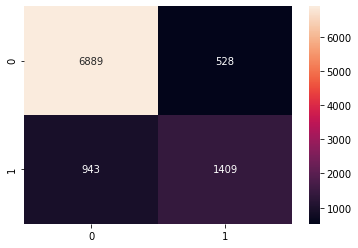

In [ ]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(Y_val, lg1.predict(X_val)), annot = True, fmt = ".0f")

Si può notare infatti notare dalla confusion matrix un recall score molto basso in quanto il numero di falsi negativi è molto vicino a quello dei veri positivi

Si può migliorare la valutazione aggiungendo un peso alle classificazioni di high income, ricordando la fase di EDA si è individuato un rateo medio di 3-4 low income per ogni high income, pertanto non si andrà oltre tali valori.
Al tempo stesso si valutano anche gli altri iperparametri con una random search

In [ ]:
grid = [
    {
      "class_weight" : [{1 : w} for w in [1.5, 2, 2.5, 3, 3.5]],
      "C" : [0.001, 0.01, 0.1, 1],
      "penalty" : ["elasticnet"],
      "l1_ratio" : [0.2, 0.5, 0.7]
    },
    {
      "class_weight" : [{1 : w} for w in [1.5, 2, 2.5, 3, 3.5]],
      "C" : [0.001, 0.01, 0.1, 1],
      "penalty" : ["l1", "l2"]   
    }
]

#result = rand_search_cv(X_train, Y_train, X_val, Y_val, LogisticRegression(solver="saga", random_state=42),  grid, 30, scoring) 


Best params : {'penalty': 'elasticnet', 'l1_ratio': 0.2, 'class_weight': {1: 2}, 'C': 1}
Best training score : 0.6925381615975521

 TRAINING TIME 

mean_fit_time      1.096574
std_fit_time       0.046919
mean_score_time    0.014412
std_score_time     0.001050
dtype: float64

 VALIDATION SET RESULTS

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      7417
           1       0.63      0.76      0.69      2352

    accuracy                           0.84      9769
   macro avg       0.77      0.81      0.79      9769
weighted avg       0.85      0.84      0.84      9769



In [ ]:
lg1 = LogisticRegression(solver="saga", penalty = 'elasticnet', l1_ratio = 0.2, class_weight =  {1: 2}, C =  1)
lg1.fit(X_train, Y_train)
print(classification_report(Y_val, lg1.predict(X_val)))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      7417
           1       0.63      0.76      0.69      2352

    accuracy                           0.84      9769
   macro avg       0.77      0.81      0.79      9769
weighted avg       0.85      0.84      0.84      9769



In questo caso utilizzare una RandomSearch con 1/5 dei parametri iniziali (30 su 100) ha fornito gli stessi risultati di una gridsearch su diverse prove e ridotto i tempi da 10 a 3 minuti.
Si è rilevato inoltre che il peso più adatto alla classe a bassa frequenza per massimizzare l'f1 score è 2

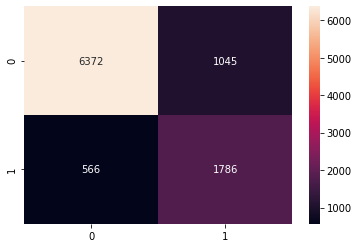

In [ ]:
sns.heatmap(confusion_matrix(Y_val, lg1.predict(X_val)), annot = True, fmt = ".0f")

I risultati sono considerevolmente migliorati: l'accuracy è aumentata dall'83 all'84%, mentre l'f1-score(probabilmente grazie ai pesi) è passata dal 60 al 69%.
L'unica pecca, come si può notare dalla confusion matrix, è che i valori di precision sono diminuiti, ma la recall è aumentata considerevolmente. Tutto sommato però il nuovo modello è decisamente migliore rispetto al precedente.

Si analizza ora il threshold dell'iperpiano per vedere se esiste un valore migliore di bilanciamento recall/precision

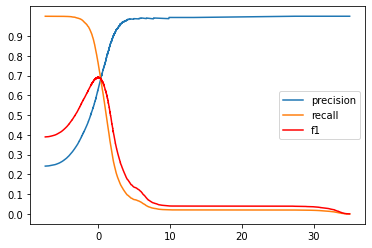

In [ ]:
display_f1_score_tradeoff(lg1)

Sembra che i valori di precision e recall si bilancino intorno al 65-69%. In questo caso non vi sono degli score di recall/precision particolarmente più alti rispetto a quelli già ottenuti. Inoltre si può notare come il valore massimo di f1 si ottiene molto vicino a questo bilanciamento ma con un valore leggermente superiore di recall (come ottenuto dal modello addestrato).


In [ ]:
entropy([ np.where(Y == 0)[0].shape[0] / X.shape[0], np.where(Y == 1)[0].shape[0] / X.shape[0]])

0.5520112931915918

Il valore di entropia di questo dataset risulta generalmente nella media(dove 0 rappresenta un dataset estremamente sbilanciato ed 1 uno perfettamente bilanciato), per questo motivo optare per tecniche di oversampling come SMOTE potrebbe non portare a risultati sperati e, anzi peggiorarli. Si testano ugualmente tali metodi per capire sia valido o meno il loro utilizzo in questo caso

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [ ]:

#sm_pipe = make_pipeline(SMOTE(random_state=1, sampling_strategy="minority"), LogisticRegression(solver="saga", random_state=42))

grid = [
    {
      "logisticregression__C" : [0.001, 0.01, 0.1, 1],
      "logisticregression__penalty" : ["elasticnet"],
      "logisticregression__l1_ratio" : [0.2, 0.5, 0.7]
    },
    {
      "logisticregression__C" : [0.001, 0.01, 0.1, 1],
      "logisticregression__penalty" : ["l1", "l2"]   
    }
]

#sm_model = rand_search_cv(X_train, Y_train, X_val, Y_val, sm_pipe, grid, 10, scoring, -1)

Best params : {'logisticregression__penalty': 'elasticnet', 'logisticregression__l1_ratio': 0.2, 'logisticregression__C': 1}
Best training score : 0.6849891534606002

 TRAINING TIME 

mean_fit_time      5.010291
std_fit_time       0.068281
mean_score_time    0.014378
std_score_time     0.001673
dtype: float64

 VALIDATION SET RESULTS

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7417
           1       0.56      0.84      0.67      2352

    accuracy                           0.80      9769
   macro avg       0.75      0.82      0.77      9769
weighted avg       0.85      0.80      0.82      9769



In [ ]:
sm_pipe = make_pipeline(SMOTE(random_state=1, sampling_strategy="minority"), 
                        LogisticRegression(solver="saga", random_state=42, penalty = 'elasticnet', l1_ratio = 0.2, C =  1))
sm_pipe.fit(X_train, Y_train)
print(classification_report(Y_val, sm_pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7417
           1       0.56      0.84      0.67      2352

    accuracy                           0.80      9769
   macro avg       0.75      0.82      0.77      9769
weighted avg       0.85      0.80      0.82      9769



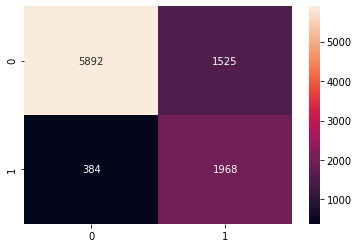

In [ ]:
sns.heatmap(confusion_matrix(Y_val, sm_pipe.predict(X_val)), annot = True, fmt = ".0f")

In questo caso infatti lo SMOTE ha portato a risultati tendenzialmente peggiori
diminuendo l'accuracy all'80% e l'f1 al 67%, inoltre si ha avuto:

*   più alta recall(i dati associati realmente ad alti guadagni sono stati classificati in maniera migliore)
*   più bassa precision(molti dei dati realmente di low_income sono stati classificati erroneamente come high_income a causa dell'oversampling) 

In sostanza  si può dire che il modello diventa tendenzialmente peggiore anche in termini di tempo di addestramento.

Un secondo approccio è quello di diminuire i dati tramite un undersampling.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

Come precedentemente con SMOTE, i dati di validazione non vengono trasformati. Il motivo principale è evitare score troppo ottimistici risultanti da un sampling anche sul validation set 

In [ ]:
#us_pipe = make_pipeline(RandomUnderSampler(random_state=42), LogisticRegression(solver="saga", random_state=42))


grid = [
    {
      "randomundersampler__sampling_strategy" : [0.5, 0.8, "majority"],
      "logisticregression__C" : [0.001, 0.01, 0.1, 1],
      "logisticregression__penalty" : ["elasticnet"],
      "logisticregression__l1_ratio" : [0.2, 0.5, 0.7]
    },
    {
      "randomundersampler__sampling_strategy" : [0.5, 0.8, "majority"],
      "logisticregression__C" : [0.001, 0.01, 0.1, 1],
      "logisticregression__penalty" : ["l1", "l2"]   
    }
]


#us_model = rand_search_cv(X_train, Y_train, X_val, Y_val, us_pipe, grid, 25, scoring, -1)


Best params : {'randomundersampler__sampling_strategy': 0.5, 'logisticregression__penalty': 'elasticnet', 'logisticregression__l1_ratio': 0.2, 'logisticregression__C': 1}
Best training score : 0.6893377253501134

 TRAINING TIME 

mean_fit_time      0.980402
std_fit_time       0.025201
mean_score_time    0.013288
std_score_time     0.000573
dtype: float64

 VALIDATION SET RESULTS

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7417
           1       0.67      0.71      0.69      2352

    accuracy                           0.84      9769
   macro avg       0.79      0.80      0.79      9769
weighted avg       0.85      0.84      0.85      9769



In [ ]:
us_pipe = make_pipeline(RandomUnderSampler(random_state=42, sampling_strategy=0.5), 
                        LogisticRegression(solver="saga", random_state=42, penalty = 'elasticnet', l1_ratio = 0.2, C =  1))
us_pipe.fit(X_train, Y_train)
print(classification_report(Y_val, us_pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7417
           1       0.67      0.71      0.69      2352

    accuracy                           0.84      9769
   macro avg       0.79      0.80      0.79      9769
weighted avg       0.85      0.84      0.85      9769



In questo caso l'undersampling ha portato a risultati quasi identici al modello iniziale.
Vi è però il vantaggio che i valori di recall e precision sono stati bilanciati meglio tra di loro, fornendo quindi un risultato maggiormente bilanciato. Inoltre essendo i dati diminuiti i tempi di addestramento risultano migliori

Si nota inoltre che dopo la trasformazione i dati più popolati sono stati ridotti a circa il doppio di quelli poco popolati, invece del vecchio rapporto 1 : 3.5

In [ ]:
_, Y_t_s = RandomUnderSampler(sampling_strategy =  0.5, random_state=42).fit_resample(X_train, Y_train)

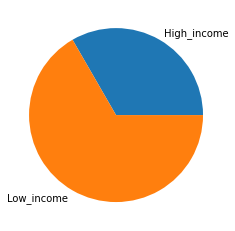

In [ ]:
plt.pie([np.count_nonzero(Y_t_s), np.count_nonzero(Y_t_s == 0)], labels= ["High_income", "Low_income"]);

Si esegue pertanto un'analisi relativa ai coefficenti appresi dal modello in undersampling

In [ ]:
pd.Series(us_pipe.named_steps["logisticregression"].coef_[0], index = full_columns_name)

age                                     0.352378
fnlwgt                                  0.074563
education.num                           0.749786
capital.gain                            2.102488
capital.loss                            0.255649
hours.per.week                          0.398004
native.country                          0.153018
workclass_Federal-gov                   0.710107
workclass_Local-gov                    -0.104050
workclass_Never-worked                  0.000000
workclass_Private                       0.040497
workclass_Self-emp-inc                  0.135218
workclass_Self-emp-not-inc             -0.374795
workclass_State-gov                    -0.378376
workclass_Without-pay                  -0.684973
marital.status_Divorced                -0.387780
marital.status_Married-AF-spouse        0.831882
marital.status_Married-civ-spouse       1.238317
marital.status_Married-spouse-absent   -0.477494
marital.status_Never-married           -0.881076
marital.status_Separ

Si può notare dai pesi assegnati che:


*   Un maggiore livello di educazione corrisponde ad un income maggiore (0.72)
*   Gli individui separati tendono a guadagnare di meno (-0.50)
*   L'occupazione pesato maggiormente dal modello è quella di manager esecutivo(0.75)

(Questi valori possono variare leggermente in seguito all'addestramento)

Nei modelli successivi per evitare risultati poco interessanti verranno fatte le seguenti modifiche:


*   si eviterà di testare ulteriormente tecniche di undersampling in quanto non hanno migliorato particolarmente il risultato (ciò ovviamente non nega che tali tecniche possano migliorare considerevolmente i risultati per modelli successivi) 
*   Gli iperparametri verranno scelti non più solo sulla base dell'f1-score ma anche dell'accuracy, infatti l'f1 individuato fino ad ora tende ad attenersi poco sotto al 69%, quindi può risultare più produttivo valutare l'accuracy , sperando che questa scelta riesca a migliorare congiuntamente l'f1_score



#Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(random_state=42)

In questo caso per non perdere le proprietà di interpretabilità dell'albero si applica alle feature numeriche uno standardScaling inverso

In [84]:
X_unscaled = np.concatenate((preprocessor.named_transformers_["num_and_categorical_high"].inverse_transform(X[:, :7]), X[:, 7:]), axis = 1)

In [85]:
X_train_u, X_val_u, Y_train_u, Y_val_u = train_test_split(X_unscaled, Y, test_size = 0.3, stratify = Y)

In [ ]:
grid = {
    "max_depth" : [5, 10, 20],
    "class_weight": [{1 : 1.5}],
    "min_samples_split" : [50, 100, 150],
    "criterion" : ["gini","entropy"]
}


#best_tree_model = rand_search_cv(X_train_u, Y_train_u, X_val_u, Y_val_u, model_tree, grid, 10, scoring, -1)

Best params : {'min_samples_split': 150, 'max_depth': 20, 'criterion': 'gini', 'class_weight': {1: 1.5}}
Best training score : 0.6814808987252533

 TRAINING TIME 

mean_fit_time      0.187060
std_fit_time       0.031192
mean_score_time    0.016850
std_score_time     0.005324
dtype: float64

 VALIDATION SET RESULTS

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      7417
           1       0.67      0.74      0.70      2352

    accuracy                           0.85      9769
   macro avg       0.79      0.81      0.80      9769
weighted avg       0.85      0.85      0.85      9769



In [ ]:
best_tree_model =  DecisionTreeClassifier(min_samples_split=150, max_depth=20, criterion="gini", class_weight={1: 1.5})
best_tree_model.fit(X_train_u, Y_train_u)
print(classification_report(Y_val_u, best_tree_model.predict(X_val_u)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      7417
           1       0.68      0.70      0.69      2352

    accuracy                           0.85      9769
   macro avg       0.79      0.80      0.79      9769
weighted avg       0.85      0.85      0.85      9769



I risultati ottenuti sono molto simili a quelli della regressione logistica, con punteggio di accuracy di poco più alto



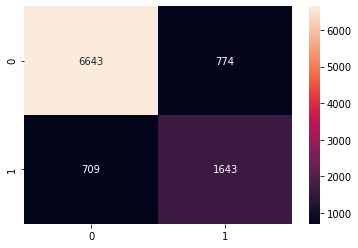

In [ ]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(Y_val_u, best_tree_model.predict(X_val_u)), annot = True, fmt = ".0f")

E' interessante notare che man mano che l'accuracy di questi modelli aumenta i valori di precision/recall tendono a bilanciarsi

In [ ]:
from sklearn.tree import export_text
print(export_text(best_tree_model, feature_names=full_columns_name))

-----------------------------------------------------


#RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier


Per risparmiare tempo si riutilizzano alcuni iperparametri individuati per gli alberi decisionali

In [ ]:
grid = {
    "n_estimators" : [100, 200, 250],
    "max_features": [5, 10, 15],
    "min_samples_split" : [150],
    "max_depth" : [20],
    "class_weight": [{1 : 1.5}],

}

#forest_model = rand_search_cv(X_train_u, Y_train_u, X_val_u, Y_val_u, RandomForestClassifier(),  grid, 9 , scoring, refit = "Accuracy") 

Best params : {'n_estimators': 250, 'min_samples_split': 150, 'max_features': 10, 'max_depth': 20, 'class_weight': {1: 1.5}}
Best training score : 0.8617494233135237

 TRAINING TIME 

mean_fit_time      3.406999
std_fit_time       0.021981
mean_score_time    0.132559
std_score_time     0.002657
dtype: float64

 VALIDATION SET RESULTS

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      7417
           1       0.73      0.70      0.71      2352

    accuracy                           0.87      9769
   macro avg       0.82      0.81      0.81      9769
weighted avg       0.86      0.87      0.86      9769



In [ ]:
forest_model =  RandomForestClassifier(n_estimators = 250, min_samples_split=150, max_depth=20, max_features= 10, class_weight={1: 1.5})
forest_model.fit(X_train_u, Y_train_u)
print(classification_report(Y_val_u, forest_model.predict(X_val_u)))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      7417
           1       0.73      0.71      0.72      2352

    accuracy                           0.87      9769
   macro avg       0.82      0.81      0.81      9769
weighted avg       0.86      0.87      0.86      9769



Si è riusciti ad inviduare un modello che raggiunge un accuracy dell' 87% ed un f1-score del 72%

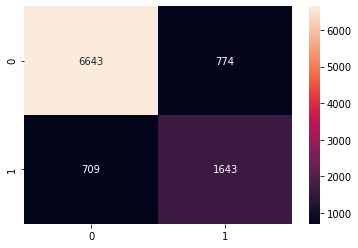

In [ ]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(Y_val_u, best_tree_model.predict(X_val_u)), annot = True, fmt = ".0f")

Nonostante il risultato positivo è probabile vi siano degli iperparametri ancora migliori che possano migliorare il risultato ulteriormente. In questo caso la valutazione è stata svolta tramite un numero limitato di essi per non aumentare eccessivamente i tempi di computazione

#XGBOOST

In [86]:
from xgboost import XGBClassifier


grid = {
    "eta" : [0.01, 0.1],
    "max_depth" : [20],
    "n_estimators" : [100, 200, 300],
    "min_child_weight" : [0.5, 1, 1.5],
    "gamma": [0.5, 1, 1.5, 2, 4]

}

#xgb_model = rand_search_cv(X_train_u, Y_train_u, X_val_u, Y_val_u, XGBClassifier(objective="binary:logistic"),  grid, 30, scoring) 

In [ ]:
xgb_model =  XGBClassifier(objective = "binary:logistic", n_estimators = 200, min_child_weight=1.5, max_depth=20, gamma = 4, eta = 0.01, class_weigth = {1: 1.5})
xgb_model.fit(X_train_u, Y_train_u)
print(classification_report(Y_val_u, xgb_model.predict(X_val_u)))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7417
           1       0.79      0.66      0.72      2352

    accuracy                           0.88      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.88      0.87      9769



I risultati in termini di accuracy sono di poco superiori a quelli della random forest (87% contro 88%), ed un f1_score al 72%. D'altra parte i valori di precision e recall sono più sbilanciati, con un maggiore accento sulla precision

A questo punto pare che xboost sia il modello con le performance tendenzialmente migliori. A questo punto sarebbe utile avere qualche informazione sul meccanismo decisionale del modello ma essendo un metodo ensable, ciò risulta difficile con metodi convenzionali.
Un'idea è utilizzare SHAP, un framework per fornire meccanismi di interpretability anche su modelli non esplicitamente interpretabili

In [91]:
#!pip install shap

In [90]:
import shap

In [93]:
interpreter = shap.TreeExplainer(xgb_model)
shap_values = interpreter.shap_values(X_val_u)

In [95]:
shap_values.shape

(9769, 49)

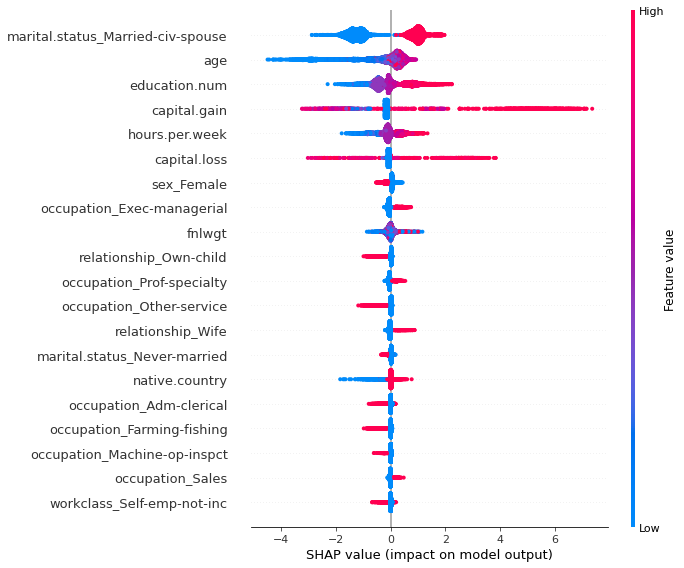

In [107]:
shap.summary_plot(shap_values, X_val_u, feature_names=full_columns_name)

Nella rappresentazione ottenuta l'asse SHAP value misura il grado di importanza positiva(verso destra) o negativa(verso sinistra) delle feature; mentre il colore rappresenta la tendenza verso low income(rosso) o high income (blue).

In questo caso non tutto è facilmente interpretabile, ma alcune caratteristiche del modello si possono individuare:





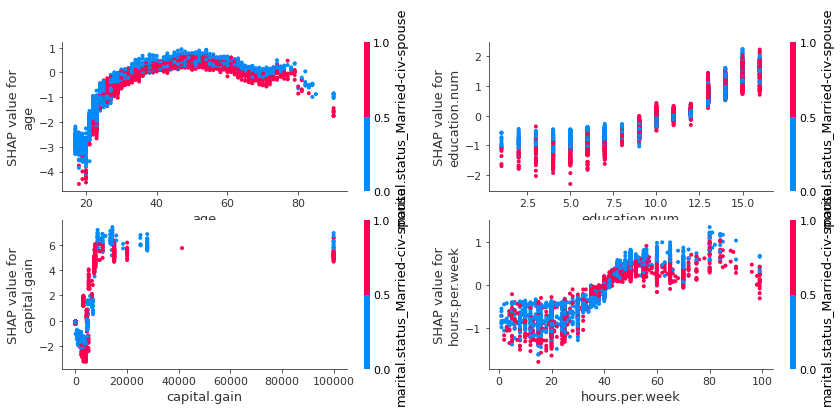

In [129]:
fig, axes = plt.subplots(2, 2, figsize = (14,6))

shap.dependence_plot("age", shap_values, X_val_u, feature_names=full_columns_name, ax=axes[0,0], show = False)
shap.dependence_plot("education.num", shap_values, X_val_u, feature_names=full_columns_name, ax=axes[0,1], show = False)
shap.dependence_plot("capital.gain", shap_values, X_val_u, feature_names=full_columns_name, ax=axes[1,0], show = False)
shap.dependence_plot("hours.per.week", shap_values, X_val_u, feature_names=full_columns_name, ax=axes[1,1], show = False)

plt.show()



*   Per quanto riguarda l'età intorno ai 20 anni la maggior parte degli individui hanno bassi income, mentre da li' in poi l'indicazione di età non fornisce risultati più precisi(si può notare che da 20 anni in poi vi sono quantità simili di high e low income); in ogni caso i valori di low income rimangono sempre preponderanti in quanto assumano maggior valore SHAP
*   Per quanto riguarda il grado di educazione, sembra che dal livello di higher education in poi l'importanza della feature aumenta leggermente(maggior SHAP value) orientandosi verso gli high income
*  La feature capital gain (avendo valori sbilanciati) tende ad avere altissimo peso nella predizione (shap value a 6, molto maggiore degli altri)
*  non vi è una relazione diretta tra numero di ore di lavoro ed income, ma si può notare come intorno alle 40 ore lavorative vi sia una preponderanza di high income (maggior shap value). Sotto le 40 ore risulta invece il contrario



#PCA

Lo scopo di questa sezione è quella di prendere in considerazione i modelli ottenuti in ogni sezione e valutare se sia possibile mantenerne la validità anche in seguito a tecniche di riduzione della dimensionalità sui dati(in questo caso PCA).
Lo scopo in questo caso è individuare un numero minore di feature per i dati, verificando se ciò abbia inpatto o meno sulle performance

In questo caso si utilizza una PCA standard, per evitare eccessive perdite di dati si punta a mantenere lungo i nuovi assi(pca) dello spazio almeno il 90% della varianza originaria dei dati

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=0.90)
pca.fit(X,Y)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.explained_variance_ratio_

array([0.15376608, 0.11458194, 0.10222691, 0.09840964, 0.08856464,
       0.08434948, 0.07009348, 0.05839597, 0.02896745, 0.02173606,
       0.01836155, 0.01620039, 0.01442786, 0.01263971, 0.0115802 ,
       0.01125769])

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.15376608, 0.26834802, 0.37057493, 0.46898457, 0.5575492 ,
       0.64189868, 0.71199216, 0.77038813, 0.79935558, 0.82109164,
       0.83945319, 0.85565358, 0.87008144, 0.88272115, 0.89430135,
       0.90555904])

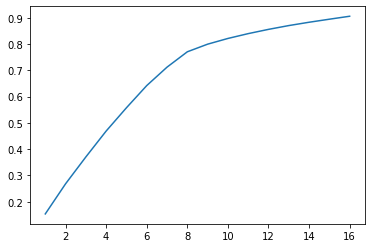

In [ ]:
plt.plot(np.arange(1,len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_));

Pare che il 90% circa della varianza dei dati originari sia descritta da 16 pca. In questo caso il numero di feature può essere ridotto da 49 a 16

In [ ]:

pca_dt = Pipeline([
    ("pca", decomposition.PCA(n_components=0.90)),
    ("dt", DecisionTreeClassifier(min_samples_split=150, max_depth=20, criterion="gini", class_weight={1: 1.5}))
])

pca_rf = Pipeline([
    ("pca", decomposition.PCA(n_components=0.90)),
    ("rf", RandomForestClassifier(n_estimators = 250, min_samples_split=150, max_depth=20, class_weight={1: 1.5}))
])

pca_xg = Pipeline([
    ("pca", decomposition.PCA(n_components=0.90)),
    ("xg", XGBClassifier(objective = "binary:logistic", n_estimators = 200, min_child_weight=1.5, max_depth=20, gamma = 4, eta = 0.01, class_weigth = {1: 1.5}))
])

pca_lr = Pipeline([
    ("pca", decomposition.PCA(n_components=0.90)),
    ("log", LogisticRegression(solver="saga", penalty = 'elasticnet', l1_ratio = 0.2, class_weight =  {1: 2}, C =  1))
])

In [ ]:
pca_rf.fit(X_train, Y_train);
pca_dt.fit(X_train, Y_train);
pca_xg.fit(X_train, Y_train);
pca_lr.fit(X_train, Y_train);

In [ ]:
print(f"Logistic Regression PCA :\n {classification_report(Y_val, pca_lr.predict(X_val))}\n")
print(f"Decision Tree PCA :\n  {classification_report(Y_val, pca_dt.predict(X_val))}\n")
print(f"Random Forest :\n {classification_report(Y_val, pca_rf.predict(X_val))}\n")
print(f"XGBOOST :\n {classification_report(Y_val, pca_xg.predict(X_val))}\n")

Logistic Regression PCA :
               precision    recall  f1-score   support

           0       0.91      0.86      0.88      7417
           1       0.62      0.73      0.67      2352

    accuracy                           0.83      9769
   macro avg       0.76      0.79      0.78      9769
weighted avg       0.84      0.83      0.83      9769


Decision Tree PCA :
                precision    recall  f1-score   support

           0       0.89      0.87      0.88      7417
           1       0.63      0.66      0.64      2352

    accuracy                           0.82      9769
   macro avg       0.76      0.77      0.76      9769
weighted avg       0.83      0.82      0.83      9769


Random Forest :
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      7417
           1       0.67      0.68      0.67      2352

    accuracy                           0.84      9769
   macro avg       0.78      0.79      0.78      9769
weight

I risultati sono tendenzialmente peggiori, ma la regressione logistica in particolare, risulta abbastanza vicina al suo valore di score originario

#EVALUTATION MODELS

In [ ]:
final_estimation = pd.DataFrame({
    ("no_PCA", "Accuracy") : [0.84, 0.85, 0.87, 0.88],
    ("no_PCA", "F1") : [0.69, 0.69, 0.71, 0.72],
    ("PCA", "Accuracy") : [0.83, 0.82, 0.84, 0.84],
    ("PCA", "F1") : [0.67, 0.64, 0.67, 0.65]
    
}, index = ["log_reg", "dec_tree", "random_forest", "xgboost"])

In [ ]:
final_estimation.head()

no_PCA            PCA      
              Accuracy    F1 Accuracy    F1
log_reg           0.84  0.69     0.83  0.67
dec_tree          0.85  0.69     0.82  0.64
random_forest     0.87  0.71     0.84  0.67
xgboost           0.88  0.72     0.84  0.65

Al momento il modello migliore risulta essere l'xgboost standard. Si calcola ora l'intervallo di confidenza di questi modelli per provare a definire come le accuratezze potrebbero comportarsi sui dati reali

In [ ]:
def get_interval_score(accuracy, N, confidence = 0.95):

  significance_level = 1 - confidence

  critical_value = norm.ppf(significance_level / 2)

  a = 2 * N * accuracy + (critical_value)**2 

  b = critical_value * np.sqrt((critical_value)**2 + 4 * N * accuracy - 4 * N * (accuracy)**2)

  c = 2 * (N + (critical_value)**2)

  return (a + b) / c, (a - b) / c

In [ ]:
for name, acc in final_estimation["no_PCA", "Accuracy"].items():
  print(f"{name} :  {get_interval_score(acc, X_val.shape[0])}\n")

La quantità di dati con cui sono stati testati i modelli è sufficiente per poter affermare la loro accuratezza in un intervallo molto ristretto (la quantità di dati era comunque molto elevata).
A questo punto si può affermare che, se i dati futuri seguono la stessa distribuzione di questi allora si può affermare con una confidenza del 95% che la loro accuratezza cadrà in questi intervalli

A questo punto prima di scegliere il modello xgboost come migliore lo si vuole comparare col secondo modello migliore in termini di performance, (la random forest) per capire se la loro differenza possa essere frutto del caso o meno. Ciò risulta utile anche perchè i loro punteggi sono abbastanza vicini tra loro

In [ ]:
def compare_models(acc1, acc2, N1, N2, confidence = 0.95):
    d = np.abs(acc1 - acc2)

    d_variance = (acc1 * (1 - acc1) / N1) + (acc2 * (1 - acc2) / N2)

    dev = norm.ppf((1 - confidence) / 2) * np.sqrt(d_variance)

    return d - dev, d + dev


In [ ]:
accuracies =final_estimation["no_PCA", "Accuracy"]

compare_models(accuracies["random_forest"], accuracies["xgboost"], X_val.shape[0], X_val.shape[0])

Risulta che la differenza tra i 2 modelli è statisticamente significativa anche se ciò risulta per poco. Si prova ora ad alzare la confidenza sopra al 95% fino per capire fino a quale valore può garantire la diversità statistica

In [ ]:
for x in np.arange(0.95, 1, 0.01):
  comp = compare_models(accuracies["random_forest"], accuracies["xgboost"], X_val.shape[0], X_val.shape[0], confidence=x)
  print(f"{x} : {np.sign(comp[0]) == np.sign(comp[1])}")

0.95 : True
0.96 : True
0.97 : False
0.98 : False
0.99 : False
1.0 : False


Pertanto si è in grado di affermare che i 2 modelli sono statisticamente diversi fino ad una confidenza del 96%

Si può quindi affermare che il modello migliore è quello ottenuto con xgboost ottenendo un'accuracy dell'88% e un f1_score del 72%

#CONSIDERAZIONI FINALI E POSSIBILI MIGLIORAMENTI

CONTESTUALIZZAZIONE DEL RISULTATO

Si è ottenuto infine un'accuratezza dell' 88% acc e 72% f1 sul modello migliore.
Per quanto riguarda i risultati più facilmente usufruibili relativi a questo dataset si hanno a disposizione i kernel pubblicati su kaggle dagli altri utenti https://www.kaggle.com/uciml/adult-census-income/code.
Il confronto con essi risulta difficile per diversi motivi: 
* Il problema è che un numero considerevole di questi kernel hanno analizzato la qualità del proprio modello solo in funzione della metrica di accuracy, ignorando spesso f1, recall e precision.
* In altri kernel seppur l'f1_score veniva considerato, questo era valutato in base all'f1_score della classe più popolosa raggiungendo quindi valori molto alti(ma che invece risultavano bassi per quella meno popolosa). 
* In altri casi ancora, sembra che si siano ottenuti score f1 molto alti sulla classe meno popolosa(intorno all'84%) con undersampling, ma il problema è che l'intero dataset(sia train che validation set) è stato trasformato in undersampling portando a stime sovra ottimistiche(si è sperimentato ciò per verificare ed effettivamente si riusciva facilmente ad ottenere alti valori di f1).

Ovviamente non potendo valutare ogni kernel è possibile si siano ottenuti 
esiti anche più positivi, ma considerando sommativamente i risultati ottenuti, si ritiene che questi siano particolarmente positivi

POSSIBILI MIGLIORAMENTI E ASSUNZIONI DI SEMPLIFICAZIONE


*   Nell'individuare gli iperparametri migliori è stata utilizzata una random search parametrizzata con uno StratifiedFold. Il motivo di ciò era evitare di raggiungere lunghi tempi di elaborazione e quindi rendere più difficoltoso svolgere test su modelli più complessi (per lo stesso motivo non si è utilizzata una nested cross validation). Un'alternativa per migliorare i tempi di elaborazione sarebbe potuta essere utilizzare un ottimizzatore bayesiano al posto della random search.
*   Per semplicità, i modelli con PCA sono stati addestrati con gli stessi iperparametri individuati con i dati non ridotti. Ciò ovviamente non garantisce che risultino gli iperparametri migliori anche per questi.
*   Seppur sia stata analizzata la correlazione lineare tra le feature, è probabile che tra le feature vi fossero dei collider (feature con multicolinearità con il target), in questo caso è probabile che la regolarizzazione abbia migliorato il problema ma poteva risultare utile unire queste feature per ottenere un insieme di feature più compatto (magari utilizzato il variance inflation factor (VIF)).
* Nella sezione di EDA si sono analizzate le distribuzioni di alcune feature, queste in molti casi presentavano degli outlier( un esempio sono capital gain/loss che possiedono un numero molto piccolo di valori diversi da 0 sul totale). Eliminandoli è probabile che i risulti possano migliorare.




